# Step 11: 2-D Laplace Equation

The 2-D Laplace equation for the function $p = p\left(x,\; y\right)$ is the following:

$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = 0$$

As already done before, we use the 2-nd order central difference scheme for the discretization of the above to get:

$$\frac{p_{i+1,\; j}^n - 2p_{i,\; j}^n + p_{i-1,\; j}^n}{\Delta x^2} + \frac{p_{i,\; j+1}^n -2p_{i,\; j}^n +p_{i,\; j-1}^n}{\Delta y^2} = 0$$

Using the symbol $n$ for the n-th iteration, we decide to evaluate $p_{i,\; j}^n$ using values from the $\left(n-1\right)th$ iteration, where $n = 0$ for the starting values of $p\left(x,\; y\right)$.

$$p_{i,\; j}^n = \frac{\Delta x^2\left(p_{i,\; j+1}^{n-1} + p_{i,\; j-1}^{n-1}\right) + \Delta y^2\left(p_{i+1,\; j}^{n-1} + p_{i-1,\; j}^{n-1}\right)}{2\left(\Delta x^2 + \Delta y^2\right)}$$

This method of evaluation is called __5-point stencil__, because it evaluates $p_{i,\; j}$ by the use of a geometrical arrangement (called _stencil_) composed of five points.

We decide to operate in this way, through trials and errors, because the solution to Laplace equation corresponds to a physical system at equilibrium, thus the numerical process will stop only when two solutions, corresponding to two following iterations, differ less than a chosen value $\epsilon$, i.e. when $||p_{i,\; j}^n - p_{i,\; j}^{n-1}|| < \epsilon$ for every point $\left(i,\; j\right)$ of the grid. This iterative procedure is called _Relaxation method_ and the norm we are going to use in this notebook is the following:

$$||p^n - p^{n-1}|| = \sum_{i,\; j} \frac{\left(|p_{i,\; j}^n - p_{i,\; j}^{n-1}|\right)}{\sum_{i,\; j} |p_{i,\; j}^{n-1}|}$$

The (Cauchy) boundary condition corresponds to:

$p \left(0,\; y\right) = 0 \;\;\wedge\;\; p \left(2,\; y\right) = y \;\;\wedge\;\; \frac{\partial p}{\partial y} \left(x,\; y\right) = 0$ for $y = 0, 1$

which is fulfilled by the following analytical solution.

$$p\left(x,\; y\right) = \frac{x}{4} - 4\times\sum_{n=1,\; odd}^{\infty}\frac{\sinh\left(n\pi x\right)\cos\left(n\pi y\right)}{\left(n\pi\right)^2 \sinh\left(2n\pi\right)}$$

The discretized version of BCs can be written as:

$p_{0,\; y} = 0 \;\;\wedge\;\; p_{-1,\; y} = y \;\;\wedge\;\; p_{i,\; 0} = p_{i,\; 1} \;\;\wedge\;\; p_{i,\; -1} = p_{i,\; -2}$

For further readings, start from here:
- [5-point stencil method](https://en.wikipedia.org/wiki/Stencil_(numerical_analysis))
- [Relaxation method](https://en.wikipedia.org/wiki/Relaxation_(iterative_method))
- [Types of boundary conditions: Dirichlet, Neuman and Cauchy](https://en.wikipedia.org/wiki/Boundary_value_problem#:~:text=.-,Types%20of%20boundary%20value%20problems,-%5Bedit%5D)

# ⚠️ ATTENTION ⚠️
Numpy and Matplotlib use different matrix notation for 2D arrays:
- Numpy: ```my_array = np.array( (A, B) )``` indicates an array of A rows and B columns, because when you print it's shown as a sequence of A vertically spaced arrays each of length B;
- Matplotlib: my_array is interpreted as a matrix with B elements on the x-axis (the horizontal axis when you picture it) and A elements on the y-axis (the vertical axis).

Thus in code, we initialize $p$ as following: ```p = np.array( (ny, nx) )```, where _ny = number of points on y dimension_ and similarly _nx_.

In [7]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

def plot2D (x, y, z, mpl = True):
    
    # To use this function, paste the following:
    
    # import numpy as np
    # from matplotlib import pyplot as plt, cm
    # from mpl_toolkits.mplot3d import Axes3D
    # import plotly.graph_objects as go
    
    if (mpl == True):   # Draw using matplotlib
        fig = plt.figure(figsize = (11,7), dpi = 100)
        ax = fig.add_subplot(111, projection = '3d')
        ax.view_init(elev=30, azim=-225, roll=0)
        X, Y = np.meshgrid(x, y)
        surf = ax.plot_surface(X, Y, z, cmap = cm.plasma)
        ax.set_xlabel("x axis")
        ax.set_ylabel("y axis")
        plt.show()
    else:   # Draw using plotly
        # fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, name='ICs', opacity=0.3),
        #                       go.Surface(z=u, x=x, y=y, name='u')])
        fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, name='u')])
        fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                     highlightcolor="limegreen", project_z=True))
        fig.update_layout(title='2D Laplace equation', autosize=False, showlegend=False, 
                          width=900, height=500, 
                          margin=dict(l=65, r=50, b=10, t=50),
                          scene=dict(xaxis_title='x position', yaxis_title='y position', zaxis_title='Value'))

        fig.show()

# Calculate the distance between two following iterations (a is after b)
def my_dist (a, b):
    ny = np.size(a, axis=0)
    nx = np.size(a, axis=1)
    return np.sum(np.abs(a - b)) / np.sum(np.abs(b))
    # return np.sum(np.abs(a) - np.abs(b)) / np.sum(np.abs(b))

def laplace2D (p, y, dx, dy, epsilon = 1e-4, max_iter = 1e5):
    iter = 0
    dist = 1
    pn = np.zeros_like(p)

    while (dist > epsilon and iter <= max_iter):

        pn = p.copy()
        # Remember: 1st index regards y-axis, 2nd index the x-axis
        p[1:-1,1:-1] = ( (pn[2:, 1:-1] + pn[0:-2, 1:-1])*dx**2 + (pn[1:-1, 2:] + pn[1:-1, 0:-2])*dy**2 ) / (2*(dx**2 + dy**2))

        # BCs:
        p[:, 0] = 0
        p[:, -1] = y
        p[0, :] = p[1, :]
        p[-1, :] = p[-2, :]
        
        # Escape terms
        dist = my_dist(p, pn)
        iter += 1

    print(iter, '/', f'{max_iter:.5e}')

    return p

In [11]:
nx = 301
ny = 301
dx = 2 / (nx - 1)
dy = 1 / (ny - 1)

x = np.linspace(0, 2, nx)
y = np.linspace(0, 1, ny)

# ATTENTION: numpy and matplotlib use different matrix notation
#   - numpy: my_array = np.array((A, B)) indicates an array of A rows and B columns
#   - matplotlib: my_array is now interpreted as an array with B rows and A columns, because it has B elements on the x-axis and A elements on the y-axis
# Thus, we define ICs as an array with numpy_rows equal to ny and numpy_cols equal to nx, but we will treat it in matplotlib way (so e.g. the first index indicates the y coordinate)

# Initial conditions
ICs = np.zeros((ny, nx))   # y-axis with ny elements, x-axis with nx elements (ny numpy-rows and nx numpy-cols)
ICs[:, 0] = 0    # p(0, y) = 0
ICs[:, -1] = y   # p(2, y) = y
ICs[-1, :] = ICs[-2, :]   # dp/dy = 0 at y = 1
ICs[0, :] = ICs[1, :]     # dp/dy = 0 at y = 0

# plot2D(x, y, ICs, mpl=False)

p = np.zeros((ny, nx))

p = laplace2D(ICs, y, dx, dy)
# plot2D(x, y, p, mpl=False)

4902 / 1.00000e+05


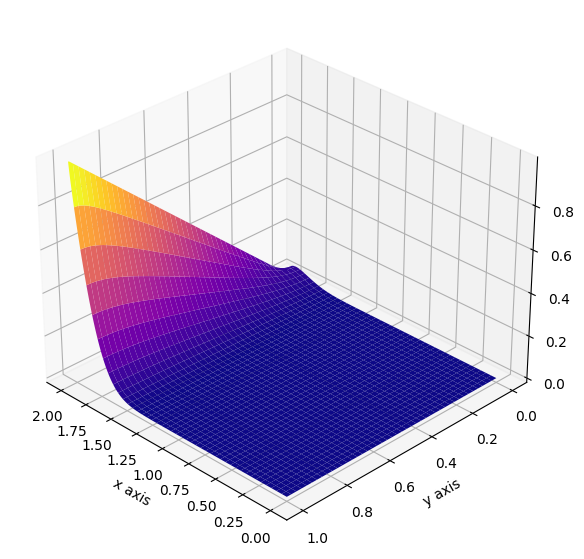

In [14]:
plot2D(x, y, p, mpl=True)